# Prerequisites

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import keras
import tensorflow as tf
import cv2
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, InputLayer
import PIL
import os
from keras.optimizers import Adam
from keras import applications
from keras.layers import Input
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix,classification_report
from shutil import copyfile, copy2
from keras.callbacks import LearningRateScheduler

In [0]:
from zipfile import ZipFile
# After uploading a file named "Set1&2.zip" to Google Colaboratory, load it. Set1&2 has roughly 40,000 images. 35,000 in train, 5,000 in test. 
file_name = "Set1&2.zip"

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print("Done")
  
# with augmentation
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(rescale=1./255,
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest')
image_shape = (50,50,3)

generator_noaug = ImageDataGenerator(rescale=1./255)
# Training Dataset (With Shuffle)
pathtrain = "/content/Set1&2/Train"
firsttrain = generator.flow_from_directory(
        pathtrain,
        target_size=image_shape[:2],
        batch_size=128,
        shuffle=True)
# Test Dataset (Without Shuffl)
pathtest = "/content/Set1&2/Test"
firsttest = generator_noaug.flow_from_directory(
        pathtest,
        target_size=image_shape[:2],
        batch_size=64,
        shuffle=False)

# Assign Class Weights
from sklearn.utils.class_weight import compute_class_weight
class_weight1 = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(firsttrain.classes),
                                    y=firsttrain.classes)
class_weight1

Done
Found 34627 images belonging to 2 classes.
Found 5883 images belonging to 2 classes.


array([1.0397874, 0.9631453])

In [0]:
# The same training dataset but without shuffle (so wrong images can be identified)
image_shape = (50,50,3)
validate_first_train = generator.flow_from_directory(
        pathtrain,
        target_size=image_shape[:2],
        batch_size=64,
        shuffle=False)

Found 34627 images belonging to 2 classes.


In [0]:
pathtest = "/content/Set1&2/Test"

secondtest = generator.flow_from_directory(
        pathtest,
        target_size=(150,150),
        batch_size=64,
        shuffle=False)

Found 5883 images belonging to 2 classes.


In [0]:
# Create directories to store images for MetaNet training
# define the names of the directories to be created
path1 = "/content/Resnet2"
path2 = "/content/Resnet2/Benign"
path3 = "/content/Resnet2/Malignant"

path4 = "/content/Resnet3"
path5 = "/content/Resnet3/Benign"
path6 = "/content/Resnet3/Malignant"

path7 = "/content/Resnet4"
path8 = "/content/Resnet4/Benign"
path9 = "/content/Resnet4/Malignant"

# ONLY RUN THIS CODE ONCE BC It makes the directories
import os
import shutil
shutil.rmtree(path2,path3)
try:
  os.mkdir(path)
  os.mkdir(path2)
  os.mkdir(path3)
  os.mkdir(path4)
  os.mkdir(path5)
  os.mkdir(path6)  
  os.mkdir(path7)
  os.mkdir(path8)
  os.mkdir(path9)
  ###os.mkdir(path4)
  
except OSError:  
  print ("Creation of the directory %s failed" % path)
else:  
  print ("Successfully created the directory %s " % path)

Successfully created the directory /content/Resnet2 


In [0]:
# Create new directories for the Ensemble Training
path1b = "/content/Resnet2b"
path2b = "/content/Resnet2b/Benign"
path3b = "/content/Resnet2b/Malignant"

path4b = "/content/Resnet3b"
path5b = "/content/Resnet3b/Benign"
path6b = "/content/Resnet3b/Malignant"

path7b = "/content/Resnet4b"
path8b = "/content/Resnet4b/Benign"
path9b = "/content/Resnet4b/Malignant"

import os
import shutil
#shutil.rmtree(path2,path3)
try:
  os.mkdir(path1b)
  os.mkdir(path2b)
  os.mkdir(path3b)
  os.mkdir(path4b)
  os.mkdir(path5b)
  os.mkdir(path6b)  
  os.mkdir(path7b)
  os.mkdir(path8b)
  os.mkdir(path9b)
  ###os.mkdir(path4)
  
except OSError:  
  print ("Creation of the directory %s failed" % path)
else:  
  print ("Successfully created the directory %s " % path)

Successfully created the directory /content/Resnet2 


In [0]:
# Prints classification report, confusion matrix, and returns a numpy array of the prediction values of the model
def performance(model, img_generator):
  img_generator.reset()
  predictions_train = model.predict_generator(img_generator,steps=img_generator.samples/img_generator.batch_size)
  rounded_real_train = []
  for item in predictions_train:
    maxx = max(item)
    rounded_real_train.append(np.where(item==maxx)[0][0])
  
  img_generator.reset()
  true_classes = img_generator.classes

  img_generator.reset()
  class_labels = list(img_generator.class_indices.keys()) 

  print(classification_report(true_classes, rounded_real_train, target_names=class_labels))  
  print(confusion_matrix(true_classes,rounded_real_train))
  return rounded_real_train

In [ ]:
# Plot Training History
def plot_training_history(results):
    
    acc = results.history['acc']
    loss = results.history['loss']
    fig1, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))

    try:
      val_acc = results.history['val_acc']
      val_loss = results.history['val_loss']
      ax1.plot(val_acc, linestyle='-', color='b', label='Validation Acc.')
      ax2.plot(val_loss, 'o', color='b', label='Training Loss')

    except:
      pass
    ax1.plot(acc, linestyle='-', color='r', label='Training Acc.')

    ax2.plot(loss, 'o', color='r', label='Training Loss')

    ax1.title.set_text('Training and Test Accuracy')
    ax2.title.set_text('Training and Test Loss')

    ax1.legend()
    ax2.legend()

In [0]:
# Prints values that can be put in an matrix: tells number of images wrong from each interdependent model. Refer to paper (table 2). 
def progress_count(predictions1, predictions2, predictions3, true_values):
  first_wrong = (predictions1 != true_values)
  second_wrong = (predictions2 != true_values)
  third_wrong = (predictions3 != true_values)
  third_wrong_copy = third_wrong.copy()
  
  num_first_wrong = sum(first_wrong)
  num_first_second_wrong = 0
  num_first_third_wrong = 0
  num_second_third_wrong = 0
  
  num_NET_third_first_wrong = 0
  index0 = -1
  for result in second_wrong:
    index0 +=1
    if result == 1 and result == first_wrong[index0]:
      num_first_second_wrong += 1
    if result == 1 and third_wrong[index0]==0:
      third_wrong_copy[index0]=1
  num_second_else_wrong = sum(second_wrong)-num_first_second_wrong

  index1 = -1
  for result1 in third_wrong:
    index1 += 1
    if result1 == 1 and result1 == first_wrong[index1]:
      num_first_third_wrong += 1
    elif result1 == 1 and result1== second_wrong[index1]:
      num_second_third_wrong += 1
  num_third_else_wrong = sum(third_wrong)-num_first_third_wrong-num_second_third_wrong

  index2 = -1
  for result2 in third_wrong_copy:
    index2+=1
    if result2 == 1 and result2 == first_wrong[index2]:
      num_NET_third_first_wrong+= 1
  
  
  return(num_first_wrong,num_first_second_wrong,num_second_else_wrong,num_first_third_wrong,num_second_third_wrong,num_third_else_wrong,num_NET_third_first_wrong)

In [0]:
# Create full path name of training images
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]
image_paths_train = path_join(pathtrain, firsttrain.filenames)
image_paths_test = path_join(pathtest, firsttest.filenames)

# Find wrong train image paths (not called anywhere except in the next function)
def generate_error_imgs(rounded_predictions,cls_test, image_paths_test):
  incorrect = (rounded_predictions != cls_test)
  image_wrong_paths = np.array(image_paths_test)[incorrect]
  return image_wrong_paths

# Adds all the wrong images into the desired benign and malignant folder
def wrong_img_folder_make(model,img_generator,benign_folder,malignant_folder,image_paths):
  true_train_classes = img_generator.classes

  rounded_real_train = performance(model,img_generator)

  wrong_train = generate_error_imgs(rounded_real_train,true_train_classes,image_paths)
  print('number of wrong imgs')
  print(wrong_train.shape)
  print('total number of trained images')
  print(len(rounded_real_train))

  for path_img in wrong_train:
    if "Benign" in str(path_img): 
      filename = path_img.split('Benign/',1)[1]
      copy2(path_img, benign_folder)
    else:
      filename = path_img.split('Malignant/',1)[1]
      copy2(path_img, malignant_folder)

# Model 1 (Repeat same process for models 2 and 3)

In [ ]:
input_tensor = Input(shape=(50, 50, 3))
from keras import regularizers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

# Fine tune the resnet 50
model = ResNet50(weights='imagenet',include_top=False,input_tensor=input_tensor)
weight_decay = 1e-3

last_layer = model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)
# add fully-connected & dropout layers
x = Dense(512, activation='relu',name='fc-1',kernel_regularizer=regularizers.l2(weight_decay))(x)
x = Dropout(0.7)(x)
x = (BatchNormalization())(x)
x = Dense(512, activation='relu',name='fc-2',kernel_regularizer=regularizers.l2(weight_decay))(x)
x = Dropout(0.7)(x)
x = (BatchNormalization())(x)
x = Dense(256, activation='relu',name='fc-3',kernel_regularizer=regularizers.l2(weight_decay),)(x)
x = Dropout(0.7)(x)
x = (BatchNormalization())(x)

# a softmax layer for 4 classes
out = Dense(2, activation='softmax',name='output_layer')(x)

In [ ]:
resnet1 = Model(inputs=model.input, outputs=out)
for layer in resnet1.layers:
    layer.trainable = True

from keras.callbacks import ModelCheckpoint

def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 10:
        lrate = 0.00005
    if epoch > 30:
        lrate = 0.00003
    return lrate

checkpoint = ModelCheckpoint('resnet1.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

resnet1.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [ ]:
resnet_model1_results = resnet1.fit_generator(firsttrain,
                              epochs=20,
                              steps_per_epoch=firsttrain.samples/firsttrain.batch_size,
                              validation_data=firsttest,
                             validation_steps=firsttest.samples/firsttest.batch_size,
                              class_weight=class_weight1,
                             callbacks=[LearningRateScheduler(lr_schedule),checkpoint])

In [ ]:
plot_training_history(resnet_model1_results)

# Find Wrong Images from Model 1 (or any Previous Model)

In [ ]:
from keras.models import load_model
resnet1 = load_model('resnet1.h5')
wrong_img_folder_make(resnet1,validate_first_train,path2,path3,image_paths_train)

# Train Complement Model on Previous Model's Image

In [ ]:
secondtrainpath = "/content/Resnet2"
secondtrain = generator.flow_from_directory(
        secondtrainpath,
        target_size=image_shape[:2],
        batch_size=18,
        shuffle=False)
from sklearn.utils.class_weight import compute_class_weight
class_weights2 = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(secondtrain.classes),
                                    y=secondtrain.classes)
class_weights2=class_weights2*class_weights2/2
print(class_weights2)

In [ ]:
resnet2 = Model(inputs=model.input, outputs=out)
for layer in resnet1.layers:
    layer.trainable = True

from keras.callbacks import ModelCheckpoint

def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 10:
        lrate = 0.00005
    if epoch > 30:
        lrate = 0.00003
    return lrate

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

resnet2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [ ]:
# Complement train on wrong images
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('resnet2_nofinetune.h5', verbose=1, monitor='loss',save_best_only=True, mode='auto')  

resnet2_nofinetune_results = resnet2.fit_generator(secondtrainpath,
                              epochs=5,
                              steps_per_epoch=secondtrainpath.samples/secondtrainpath.batch_size,
                              validation_data=firsttest,
                             validation_steps=firsttest.samples/firsttest.batch_size,
                              callbacks=[checkpoint],class_weight=class_weights2)

In [ ]:
# Complement train on wrong images
resnet2 = load_model('resnet2_nofinetune.h5')

checkpoint2 = ModelCheckpoint('resnet2_finetune.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

resnet2_nofinetune_results = resnet2.fit_generator(firsttrain,
                              epochs=5,
                              steps_per_epoch=firsttrain.samples/firsttrain.batch_size,
                              validation_data=firsttest,
                             validation_steps=firsttest.samples/firsttest.batch_size,
                              callbacks=[checkpoint2],class_weight=class_weight1)

# Find Wrong Images from Model 1 (or any Previous Model)

In [ ]:
from keras.models import load_model
resnet1 = load_model('resnet1.h5')
wrong_img_folder_make(resnet1,validate_first_train,path2,path3,image_paths_train)

# Train Complement Model on Previous Model's Image

In [ ]:
secondtrainpath = "/content/Resnet2"
secondtrain = generator.flow_from_directory(
        secondtrainpath,
        target_size=image_shape[:2],
        batch_size=18,
        shuffle=False)
from sklearn.utils.class_weight import compute_class_weight
class_weights2 = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(secondtrain.classes),
                                    y=secondtrain.classes)
class_weights2=class_weights2*class_weights2/2
print(class_weights2)

In [ ]:
resnet2 = Model(inputs=model.input, outputs=out)
for layer in resnet1.layers:
    layer.trainable = True

from keras.callbacks import ModelCheckpoint

def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 10:
        lrate = 0.00005
    if epoch > 30:
        lrate = 0.00003
    return lrate

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

resnet2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [ ]:
# Complement train on wrong images
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('resnet2_nofinetune.h5', verbose=1, monitor='loss',save_best_only=True, mode='auto')  

resnet2_nofinetune_results = resnet2.fit_generator(secondtrain,
                              epochs=5,
                              steps_per_epoch=secondtrain.samples/secondtrain.batch_size,
                              validation_data=firsttest,
                             validation_steps=firsttest.samples/firsttest.batch_size,
                              callbacks=[checkpoint],class_weight=class_weights2)

In [ ]:
# Complement train on wrong images
resnet2 = load_model('resnet2_nofinetune.h5')

checkpoint2 = ModelCheckpoint('resnet2_finetune.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

resnet2_nofinetune_results = resnet2.fit_generator(firsttrain,
                              epochs=5,
                              steps_per_epoch=firsttrain.samples/firsttrain.batch_size,
                              validation_data=firsttest,
                             validation_steps=firsttest.samples/firsttest.batch_size,
                              callbacks=[checkpoint2],class_weight=class_weight1)

# Third

In [ ]:
from keras.models import load_model
resnet2 = load_model('resnet2_finetune.h5')
wrong_img_folder_make(resnet2,validate_first_train,path5,path6,image_paths_train)

In [ ]:
thirdtrainpath = "/content/Resnet3"
thirdtrain = generator.flow_from_directory(
        thirdtrainpath,
        target_size=image_shape[:2],
        batch_size=18,
        shuffle=False)
from sklearn.utils.class_weight import compute_class_weight
class_weights3 = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(thirdtrain.classes),
                                    y=thirdtrain.classes)
class_weights3=class_weights3*class_weights3/2
print(class_weights3)

In [ ]:
resnet3 = Model(inputs=model.input, outputs=out)
for layer in resnet3.layers:
    layer.trainable = True

from keras.callbacks import ModelCheckpoint

def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 10:
        lrate = 0.00005
    if epoch > 30:
        lrate = 0.00003
    return lrate

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

resnet3.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [ ]:
# Complement train on wrong images
from keras.callbacks import ModelCheckpoint

checkpoint3a = ModelCheckpoint('resnet3_nofinetune.h5', verbose=1, monitor='loss',save_best_only=True, mode='auto')  

resnet3_nofinetune_results = resnet3.fit_generator(thirdtrain,
                              epochs=5,
                              steps_per_epoch=thirdtrain.samples/thirdtrain.batch_size,
                              validation_data=firsttest,
                             validation_steps=firsttest.samples/firsttest.batch_size,
                              callbacks=[checkpoint3a],class_weight=class_weights3)

In [ ]:
# Complement train on wrong images
resnet3 = load_model('resnet3_nofinetune.h5')

checkpoint3b = ModelCheckpoint('resnet3_finetune.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

resnet3_nofinetune_results = resnet3.fit_generator(firsttrain,
                              epochs=5,
                              steps_per_epoch=firsttrain.samples/firsttrain.batch_size,
                              validation_data=firsttest,
                             validation_steps=firsttest.samples/firsttest.batch_size,
                              callbacks=[checkpoint3b],class_weight=class_weight1)

# Refinetuned

In [ ]:
from keras.models import load_model
resnet3 = load_model('resnet3_finetune.h5')
wrong_img_folder_make(resnet3,validate_first_train,path8,path9,image_paths_train)

In [ ]:
thirdtrainpath = "/content/Resnet3"
thirdtrain = generator.flow_from_directory(
        thirdtrainpath,
        target_size=image_shape[:2],
        batch_size=18,
        shuffle=False)
from sklearn.utils.class_weight import compute_class_weight
class_weights3 = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(thirdtrain.classes),
                                    y=thirdtrain.classes)
class_weights3=class_weights3*class_weights3/2
print(class_weights3)

In [ ]:
resnet3 = Model(inputs=model.input, outputs=out)
for layer in resnet3.layers:
    layer.trainable = True

from keras.callbacks import ModelCheckpoint

def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 10:
        lrate = 0.00005
    if epoch > 30:
        lrate = 0.00003
    return lrate

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

resnet3.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [ ]:
# Complement train on wrong images
from keras.callbacks import ModelCheckpoint

checkpoint3a = ModelCheckpoint('resnet3_nofinetune.h5', verbose=1, monitor='loss',save_best_only=True, mode='auto')  

resnet3_nofinetune_results = resnet3.fit_generator(thirdtrainpath,
                              epochs=5,
                              steps_per_epoch=thirdtrainpath.samples/thirdtrainpath.batch_size,
                              validation_data=firsttest,
                             validation_steps=firsttest.samples/firsttest.batch_size,
                              callbacks=[checkpoint3a],class_weight=class_weights3)

In [ ]:
# Complement train on wrong images
resnet3 = load_model('resnet3_nofinetune.h5')

checkpoint3b = ModelCheckpoint('resnet3_finetune.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

resnet3_nofinetune_results = resnet3.fit_generator(firsttrain,
                              epochs=5,
                              steps_per_epoch=firsttrain.samples/firsttrain.batch_size,
                              validation_data=firsttest,
                             validation_steps=firsttest.samples/firsttest.batch_size,
                              callbacks=[checkpoint3b],class_weight=class_weight1)

In [0]:
# Find ROC Values of different resnet predictions
import numpy as np
from sklearn import metrics
firsttest.reset()
fpr1, tpr1, thresholds1 = metrics.roc_curve(firsttest.classes, resnet1_test)
print(metrics.auc(fpr1, tpr1))
firsttest.reset()
fpr2, tpr2, thresholds2 = metrics.roc_curve(firsttest.classes, resnet2_test)
print(metrics.auc(fpr2, tpr2))
firsttest.reset()
fpr3, tpr3, thresholds3 = metrics.roc_curve(firsttest.classes, resnet3_test)
print(metrics.auc(fpr3, tpr3))

0.8768807345821786
0.8720635119084829
0.8750958513054531


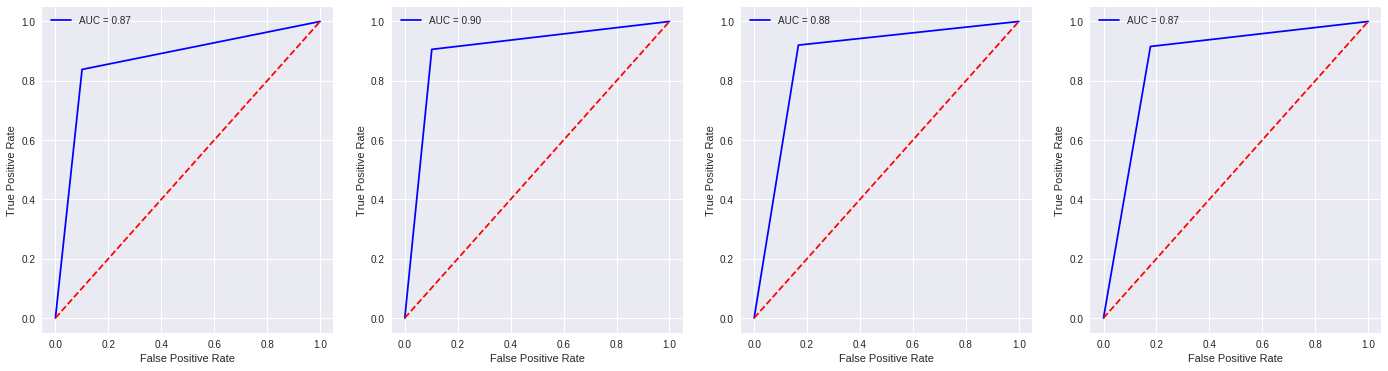

In [0]:
# Create ROC Curve Graphs
fig1, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4,figsize=(24, 6))

#plt.title('Receiver Operating Characteristic')
ax1.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % auc1)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.legend()
ax2.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % auc2)
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')
ax2.legend()
ax3.plot(fpr3, tpr3, 'b', label = 'AUC = %0.2f' % auc3)
ax3.plot([0, 1], [0, 1],'r--')
ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')
ax3.legend()
ax4.plot(fpr4, tpr4, 'b', label = 'AUC = %0.2f' % auc4)
ax4.plot([0, 1], [0, 1],'r--')
ax4.set_ylabel('True Positive Rate')
ax4.set_xlabel('False Positive Rate')
ax4.legend()

In [0]:
# Creating Folders Containing Images that Previous Model got Wrong
wrong_img_folder_make(resnet1,validate_first_train,path2,path3,image_paths_train)
wrong_img_folder_make(resnet2,validate_first_train,path5,path6,image_paths_train)
wrong_img_folder_make(resnet3,validate_first_train,path8,path9,image_paths_train)

              precision    recall  f1-score   support

      Benign       0.95      0.93      0.94     16651
   Malignant       0.94      0.96      0.95     17976

   micro avg       0.95      0.95      0.95     34627
   macro avg       0.95      0.95      0.95     34627
weighted avg       0.95      0.95      0.95     34627

[[15515  1136]
 [  738 17238]]
number of wrong imgs
(1874,)
total number of trained images
34627
              precision    recall  f1-score   support

      Benign       0.94      0.94      0.94     16651
   Malignant       0.94      0.94      0.94     17976

   micro avg       0.94      0.94      0.94     34627
   macro avg       0.94      0.94      0.94     34627
weighted avg       0.94      0.94      0.94     34627

[[15597  1054]
 [ 1038 16938]]
number of wrong imgs
(2092,)
total number of trained images
34627
              precision    recall  f1-score   support

      Benign       0.92      0.88      0.90     16651
   Malignant       0.90      0.93      0.91

In [0]:

second_wrong_train = generator_noaug.flow_from_directory(
        path4,
        target_size=image_shape[:2],
        batch_size=64,
        shuffle=False)
third_wrong_train = generator_noaug.flow_from_directory(
        path7,
        target_size=image_shape[:2],
        batch_size=64,
        shuffle=False)

Found 1874 images belonging to 2 classes.
Found 2092 images belonging to 2 classes.
Found 3272 images belonging to 2 classes.


In [0]:
# Assessing the complement model's ability on the previous model's wrong images
resnet2_wrong_train = performance(resnet2,first_wrong_train)
resnet3_wrong_train = performance(resnet3,second_wrong_train)
resnet1_wrong_train = performance(resnet1,third_wrong_train)

              precision    recall  f1-score   support

      Benign       0.66      0.56      0.60      1136
   Malignant       0.45      0.55      0.50       738

   micro avg       0.56      0.56      0.56      1874
   macro avg       0.55      0.56      0.55      1874
weighted avg       0.58      0.56      0.56      1874

[[635 501]
 [329 409]]
              precision    recall  f1-score   support

      Benign       0.43      0.36      0.39      1054
   Malignant       0.44      0.51      0.47      1038

   micro avg       0.44      0.44      0.44      2092
   macro avg       0.44      0.44      0.43      2092
weighted avg       0.43      0.44      0.43      2092

[[380 674]
 [506 532]]
              precision    recall  f1-score   support

      Benign       0.77      0.65      0.71      1943
   Malignant       0.58      0.71      0.64      1329

   micro avg       0.68      0.68      0.68      3272
   macro avg       0.68      0.68      0.67      3272
weighted avg       0.69     

In [0]:
# 
wrong_img_folder_make(resnet1,firsttest,path2b,path3b,image_paths_test)
wrong_img_folder_make(resnet2,firsttest,path5b,path6b,image_paths_test)
wrong_img_folder_make(resnet3,firsttest,path8b,path9b,image_paths_test)

              precision    recall  f1-score   support

      Benign       0.88      0.86      0.87      2823
   Malignant       0.88      0.89      0.88      3060

   micro avg       0.88      0.88      0.88      5883
   macro avg       0.88      0.88      0.88      5883
weighted avg       0.88      0.88      0.88      5883

[[2436  387]
 [ 334 2726]]
number of wrong imgs
(721,)
total number of trained images
5883
              precision    recall  f1-score   support

      Benign       0.86      0.87      0.87      2823
   Malignant       0.88      0.87      0.88      3060

   micro avg       0.87      0.87      0.87      5883
   macro avg       0.87      0.87      0.87      5883
weighted avg       0.87      0.87      0.87      5883

[[2466  357]
 [ 396 2664]]
number of wrong imgs
(753,)
total number of trained images
5883
              precision    recall  f1-score   support

      Benign       0.88      0.86      0.87      2823
   Malignant       0.87      0.89      0.88      3060



In [0]:
first_wrong_test = generator_noaug.flow_from_directory(
        path1b,
        target_size=image_shape[:2],
        batch_size=64,
        shuffle=False)
second_wrong_test = generator_noaug.flow_from_directory(
        path4b,
        target_size=image_shape[:2],
        batch_size=64,
        shuffle=False)
third_wrong_test = generator_noaug.flow_from_directory(
        path7b,
        target_size=image_shape[:2],
        batch_size=64,
        shuffle=False)

Found 721 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 731 images belonging to 2 classes.


In [0]:
resnet2_wrong_test = performance(resnet2,first_wrong_test)
resnet3_wrong_test = performance(resnet3,second_wrong_test)
resnet1_wrong_test = performance(resnet1,third_wrong_test)

              precision    recall  f1-score   support

      Benign       0.36      0.36      0.36       387
   Malignant       0.25      0.24      0.24       334

   micro avg       0.31      0.31      0.31       721
   macro avg       0.30      0.30      0.30       721
weighted avg       0.31      0.31      0.31       721

[[140 247]
 [253  81]]
              precision    recall  f1-score   support

      Benign       0.32      0.30      0.31       357
   Malignant       0.39      0.41      0.40       396

   micro avg       0.36      0.36      0.36       753
   macro avg       0.35      0.36      0.36       753
weighted avg       0.36      0.36      0.36       753

[[108 249]
 [234 162]]
              precision    recall  f1-score   support

      Benign       0.36      0.32      0.34       398
   Malignant       0.27      0.30      0.29       333

   micro avg       0.31      0.31      0.31       731
   macro avg       0.31      0.31      0.31       731
weighted avg       0.32     

In [0]:
resnet1_train = performance(resnet1,validate_first_train)
resnet2_train = performance(resnet2,validate_first_train)
resnet3_train = performance(resnet3,validate_first_train)
resnet1_test=performance(resnet1,firsttest)
resnet2_test = performance(resnet2,firsttest)
resnet3_test = performance(resnet3,firsttest)

              precision    recall  f1-score   support

      Benign       0.95      0.93      0.94     16651
   Malignant       0.94      0.96      0.95     17976

   micro avg       0.95      0.95      0.95     34627
   macro avg       0.95      0.95      0.95     34627
weighted avg       0.95      0.95      0.95     34627

[[15555  1096]
 [  752 17224]]
              precision    recall  f1-score   support

      Benign       0.94      0.94      0.94     16651
   Malignant       0.94      0.94      0.94     17976

   micro avg       0.94      0.94      0.94     34627
   macro avg       0.94      0.94      0.94     34627
weighted avg       0.94      0.94      0.94     34627

[[15586  1065]
 [ 1043 16933]]
              precision    recall  f1-score   support

      Benign       0.92      0.88      0.90     16651
   Malignant       0.90      0.93      0.91     17976

   micro avg       0.91      0.91      0.91     34627
   macro avg       0.91      0.91      0.91     34627
weighted avg

In [0]:
a,b,c,d,e,f,g=progress_count(resnet1_train,resnet2_train,resnet3_train,validate_first_train.classes)
print(a,b,c,d,e,f,g)

1848 868 1240 1148 568 1528 1330


In [0]:
a,b,c,d,e,f,g=progress_count(resnet1_test,resnet2_test,resnet3_test,firsttest.classes)
print(a,b,c,d,e,f,g)

721 500 253 502 89 140 608


In [0]:
a,b,c,d,e,f,g=progress_count(resnet1_test,resnet2_test,resnet3_test,firsttest.classes)

779 389 187 389 98 229 487


In [0]:
resnet1_train = performance(resnet1,validate_first_train)
resnet2_train = performance(resnet2,validate_first_train)
resnet3_train = performance(resnet3,validate_first_train)

              precision    recall  f1-score   support

      Benign       0.95      0.93      0.94     16651
   Malignant       0.94      0.96      0.95     17976

   micro avg       0.95      0.95      0.95     34627
   macro avg       0.95      0.95      0.95     34627
weighted avg       0.95      0.95      0.95     34627

[[15549  1102]
 [  734 17242]]
              precision    recall  f1-score   support

      Benign       0.94      0.94      0.94     16651
   Malignant       0.94      0.94      0.94     17976

   micro avg       0.94      0.94      0.94     34627
   macro avg       0.94      0.94      0.94     34627
weighted avg       0.94      0.94      0.94     34627

[[15584  1067]
 [ 1021 16955]]
              precision    recall  f1-score   support

      Benign       0.92      0.88      0.90     16651
   Malignant       0.90      0.93      0.91     17976

   micro avg       0.91      0.91      0.91     34627
   macro avg       0.91      0.91      0.91     34627
weighted avg

In [0]:
a,b,c,d,e,f,g=progress_count(resnet2_test,resnet3_test,resnet1_test,firsttest.classes)

In [0]:
print(a,b,c,d,e,f,g)

588 387 332 382 149 238 459


In [0]:
#resnet1_test = performance(resnet1,firsttest)
resnet1_test = performance(resnet1,secondtest)
resnet2_test = performance(resnet2,secondtest)
resnet3_test = performance(resnet3,secondtest)



              precision    recall  f1-score   support

      Benign       0.90      0.82      0.86      2823
   Malignant       0.85      0.91      0.88      3060

   micro avg       0.87      0.87      0.87      5883
   macro avg       0.87      0.87      0.87      5883
weighted avg       0.87      0.87      0.87      5883

[[2317  506]
 [ 263 2797]]
              precision    recall  f1-score   support

      Benign       0.90      0.90      0.90      2823
   Malignant       0.90      0.90      0.90      3060

   micro avg       0.90      0.90      0.90      5883
   macro avg       0.90      0.90      0.90      5883
weighted avg       0.90      0.90      0.90      5883

[[2530  293]
 [ 295 2765]]
              precision    recall  f1-score   support

      Benign       0.91      0.83      0.87      2823
   Malignant       0.86      0.92      0.89      3060

   micro avg       0.88      0.88      0.88      5883
   macro avg       0.88      0.88      0.88      5883
weighted avg       0

In [0]:
wrong_img_folder_make(resnet3,validate_first_train,path8,path9,image_paths_train)

              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97     16651
   Malignant       0.97      0.98      0.97     17976

   micro avg       0.97      0.97      0.97     34627
   macro avg       0.97      0.97      0.97     34627
weighted avg       0.97      0.97      0.97     34627

[[16086   565]
 [  424 17552]]
number of wrong imgs
(989,)
total number of trained images
34627


In [0]:


thirdtrainpath = "/content/Resnet3"
thirdtrain = generator.flow_from_directory(
        thirdtrainpath,
        target_size=image_shape[:2],
        batch_size=18,
        shuffle=False)
from sklearn.utils.class_weight import compute_class_weight
class_weights3 = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(thirdtrain.classes),
                                    y=thirdtrain.classes)
class_weights3=class_weights3*class_weights3/2
print(class_weights3)

fourthtrainpath = "/content/Resnet4"
fourthtrain = generator.flow_from_directory(
        fourthtrainpath,
        target_size=image_shape[:2],
        batch_size=18,
        shuffle=False)
from sklearn.utils.class_weight import compute_class_weight
class_weights4 = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(fourthtrain.classes),
                                    y=fourthtrain.classes)
class_weights4=class_weights4*class_weights4/2
print(class_weights4)

Found 1810 images belonging to 2 classes.
[0.35502473 0.75598214]
Found 2455 images belonging to 2 classes.
[0.32694106 0.85809194]
Found 989 images belonging to 2 classes.
[0.38300611 0.68009704]


In [0]:
resnet1_test_wrong = performance(resnet1,secondtrain)
resnet2_test_wrong = performance(resnet2,secondtrain)
resnet3_test_wrong = performance(resnet3,secondtrain)

resnet1_train_wrong = performance(resnet1,thirdtrain)
resnet2_train_wrong = performance(resnet2,thirdtrain)
resnet3_train_wrong = performance(resnet3,thirdtrain)

resnet1_train_wrong2 = performance(resnet1,fourthtrain)
resnet2_train_wrong2 = performance(resnet2,fourthtrain)
resnet3_train_wrong2 = performance(resnet3,fourthtrain)

print(resnet1_test_wrong,resnet2_test_wrong,resnet3_test_wrong)
print(resnet1_train_wrong,resnet2_train_wrong,resnet3_train_wrong)
print(resnet1_train_wrong2,resnet2_train_wrong2,resnet3_train_wrong2)

              precision    recall  f1-score   support

      Benign       0.54      0.40      0.46      1074
   Malignant       0.36      0.50      0.42       736

   micro avg       0.44      0.44      0.44      1810
   macro avg       0.45      0.45      0.44      1810
weighted avg       0.47      0.44      0.44      1810

[[429 645]
 [367 369]]
              precision    recall  f1-score   support

      Benign       0.57      0.41      0.48      1074
   Malignant       0.39      0.56      0.46       736

   micro avg       0.47      0.47      0.47      1810
   macro avg       0.48      0.48      0.47      1810
weighted avg       0.50      0.47      0.47      1810

[[437 637]
 [327 409]]
              precision    recall  f1-score   support

      Benign       0.85      0.77      0.81      1074
   Malignant       0.70      0.81      0.75       736

   micro avg       0.78      0.78      0.78      1810
   macro avg       0.78      0.79      0.78      1810
weighted avg       0.79     

In [0]:
input_tensor = Input(shape=(50, 50, 3))
from keras import regularizers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

# Fine tune the resnet 50
model = ResNet50(weights='imagenet',include_top=False,input_tensor=input_tensor)
weight_decay = 1e-3

last_layer = model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)
# add fully-connected & dropout layers
x = Dense(512, activation='relu',name='fc-1',kernel_regularizer=regularizers.l2(weight_decay))(x)
x = Dropout(0.7)(x)
x = (BatchNormalization())(x)
x = Dense(512, activation='relu',name='fc-2',kernel_regularizer=regularizers.l2(weight_decay))(x)
x = Dropout(0.7)(x)
x = (BatchNormalization())(x)
x = Dense(256, activation='relu',name='fc-3',kernel_regularizer=regularizers.l2(weight_decay),)(x)
x = Dropout(0.7)(x)
x = (BatchNormalization())(x)

# a softmax layer for 4 classes
out = Dense(2, activation='softmax',name='output_layer')(x)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
resnet2 = Model(inputs=model.input, outputs=out)
for layer in resnet2.layers:
	layer.trainable = True

In [0]:
# this is the model we will train
from keras.callbacks import ModelCheckpoint

def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 10:
        lrate = 0.00005
    if epoch > 30:
        lrate = 0.00003
    return lrate

checkpoint = ModelCheckpoint('resnet2_first.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  


opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

resnet2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [0]:
resnet_model2_results = resnet2.fit_generator(firsttrain,
                              epochs=20,
                              steps_per_epoch=firsttrain.samples/firsttrain.batch_size,
                              validation_data=firsttest,
                             validation_steps=firsttest.samples/firsttest.batch_size,
                              class_weight=class_weight,
                             callbacks=[LearningRateScheduler(lr_schedule),checkpoint])

Epoch 1/20
271/270 [==============================] - 209s 769ms/step - loss: 2.4181 - acc: 0.6524 - val_loss: 2.1331 - val_acc: 0.8174

Epoch 00001: val_loss improved from inf to 2.13308, saving model to resnet2_first.h5
Epoch 2/20
271/270 [==============================] - 118s 435ms/step - loss: 2.0675 - acc: 0.7879 - val_loss: 2.0122 - val_acc: 0.8412

Epoch 00002: val_loss improved from 2.13308 to 2.01215, saving model to resnet2_first.h5
Epoch 3/20
271/270 [==============================] - 118s 434ms/step - loss: 1.8623 - acc: 0.8145 - val_loss: 1.8085 - val_acc: 0.8424

Epoch 00003: val_loss improved from 2.01215 to 1.80854, saving model to resnet2_first.h5
Epoch 4/20
271/270 [==============================] - 118s 434ms/step - loss: 1.5938 - acc: 0.8391 - val_loss: 1.7023 - val_acc: 0.7564

Epoch 00004: val_loss improved from 1.80854 to 1.70229, saving model to resnet2_first.h5
Epoch 5/20
271/270 [==============================] - 118s 434ms/step - loss: 1.3257 - acc: 0.8533 -